# Softmax exercise

*Complete and hand in this completed worksheet (including its outputs and any supporting code outside of the worksheet) with your assignment submission. For more details see the [assignments page](http://vision.stanford.edu/teaching/cs231n/assignments.html) on the course website.*

This exercise is analogous to the SVM exercise. You will:

- implement a fully-vectorized **loss function** for the Softmax classifier
- implement the fully-vectorized expression for its **analytic gradient**
- **check your implementation** with numerical gradient
- use a validation set to **tune the learning rate and regularization** strength
- **optimize** the loss function with **SGD**

- **visualize** the final learned weights


In [5]:
from __future__ import print_function
import random
import numpy as np
from cs231n.data_utils import load_CIFAR10
import matplotlib.pyplot as plt

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading extenrnal modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2
print ("setup done\n")

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
setup done



In [6]:
def get_CIFAR10_data(num_training=49000, num_validation=1000, num_test=1000, num_dev=500):
    """
    Load the CIFAR-10 dataset from disk and perform preprocessing to prepare
    it for the linear classifier. These are the same steps as we used for the
    SVM, but condensed to a single function.  
    """
    # Load the raw CIFAR-10 data
    cifar10_dir = 'cs231n/datasets/cifar-10-batches-py'
    
    X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)
    
    # subsample the data
    mask = list(range(num_training, num_training + num_validation))
    X_val = X_train[mask]
    y_val = y_train[mask]
    mask = list(range(num_training))
    X_train = X_train[mask]
    y_train = y_train[mask]
    mask = list(range(num_test))
    X_test = X_test[mask]
    y_test = y_test[mask]
    mask = np.random.choice(num_training, num_dev, replace=False)
    X_dev = X_train[mask]
    y_dev = y_train[mask]
    
    # Preprocessing: reshape the image data into rows
    X_train = np.reshape(X_train, (X_train.shape[0], -1))
    X_val = np.reshape(X_val, (X_val.shape[0], -1))
    X_test = np.reshape(X_test, (X_test.shape[0], -1))
    X_dev = np.reshape(X_dev, (X_dev.shape[0], -1))
    
    # Normalize the data: subtract the mean image
    mean_image = np.mean(X_train, axis = 0)
    X_train -= mean_image
    X_val -= mean_image
    X_test -= mean_image
    X_dev -= mean_image
    
    # add bias dimension and transform into columns
    X_train = np.hstack([X_train, np.ones((X_train.shape[0], 1))])
    X_val = np.hstack([X_val, np.ones((X_val.shape[0], 1))])
    X_test = np.hstack([X_test, np.ones((X_test.shape[0], 1))])
    X_dev = np.hstack([X_dev, np.ones((X_dev.shape[0], 1))])
    
    return X_train, y_train, X_val, y_val, X_test, y_test, X_dev, y_dev


# Cleaning up variables to prevent loading data multiple times (which may cause memory issue)
try:
   del X_train, y_train
   del X_test, y_test
   print('Clear previously loaded data.')
except:
   pass

# Invoke the above function to get our data.
X_train, y_train, X_val, y_val, X_test, y_test, X_dev, y_dev = get_CIFAR10_data()
print('Train data shape: ', X_train.shape)
print('Train labels shape: ', y_train.shape)
print('Validation data shape: ', X_val.shape)
print('Validation labels shape: ', y_val.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)
print('dev data shape: ', X_dev.shape)
print('dev labels shape: ', y_dev.shape)

Clear previously loaded data.
Train data shape:  (49000, 3073)
Train labels shape:  (49000,)
Validation data shape:  (1000, 3073)
Validation labels shape:  (1000,)
Test data shape:  (1000, 3073)
Test labels shape:  (1000,)
dev data shape:  (500, 3073)
dev labels shape:  (500,)


## Softmax Classifier

Your code for this section will all be written inside **cs231n/classifiers/softmax.py**. 


In [8]:
# First implement the naive softmax loss function with nested loops.
# Open the file cs231n/classifiers/softmax.py and implement the
# softmax_loss_naive function.

from cs231n.classifiers.softmax import softmax_loss_naive
import time

# Generate a random softmax weight matrix and use it to compute the loss.
W = np.random.randn(3073, 10) * 0.0001
loss, grad = softmax_loss_naive(W, X_dev, y_dev, 0.0)

# As a rough sanity check, our loss should be something close to -log(0.1).
print('loss: %f' % loss)
print('sanity check: %f' % (-np.log(0.1)))

loss: 2.334109
sanity check: 2.302585


## Inline Question 1:
Why do we expect our loss to be close to -log(0.1)? Explain briefly.**

**Your answer:** * For our data, there are 10 possible classes and only one correct class for the ground truth tables. There is a 0.1 chance of random guess for each class, our loss is giving unnormalised negative log probabilities of each class so should be close to -log(0.1) at the start (random guess). *


In [10]:
# Complete the implementation of softmax_loss_naive and implement a (naive)
# version of the gradient that uses nested loops.
loss, grad = softmax_loss_naive(W, X_dev, y_dev, 0.0)

# As we did for the SVM, use numeric gradient checking as a debugging tool.
# The numeric gradient should be close to the analytic gradient.
from cs231n.gradient_check import grad_check_sparse
f = lambda w: softmax_loss_naive(w, X_dev, y_dev, 0.0)[0]
grad_numerical = grad_check_sparse(f, W, grad, 10)

# similar to SVM case, do another gradient check with regularization
loss, grad = softmax_loss_naive(W, X_dev, y_dev, 5e1)
f = lambda w: softmax_loss_naive(w, X_dev, y_dev, 5e1)[0]
grad_numerical = grad_check_sparse(f, W, grad, 10)
print ("done checking :) \n ")

numerical: 2.165246 analytic: 2.165246, relative error: 4.476693e-08
numerical: -0.863869 analytic: -0.863870, relative error: 1.692829e-08
numerical: -0.243418 analytic: -0.243418, relative error: 1.595240e-07
numerical: 3.573190 analytic: 3.573190, relative error: 2.497173e-08
numerical: -1.534077 analytic: -1.534077, relative error: 9.325362e-09
numerical: -0.585371 analytic: -0.585371, relative error: 5.199210e-08
numerical: -2.554850 analytic: -2.554850, relative error: 5.046925e-09
numerical: 0.770071 analytic: 0.770071, relative error: 6.735276e-08
numerical: 0.996441 analytic: 0.996440, relative error: 1.859009e-08
numerical: 3.407291 analytic: 3.407291, relative error: 8.668087e-09
numerical: 2.490740 analytic: 2.490739, relative error: 3.269095e-08
numerical: 0.018444 analytic: 0.018444, relative error: 1.160115e-06
numerical: 0.086835 analytic: 0.086835, relative error: 6.972341e-07
numerical: -0.788320 analytic: -0.788320, relative error: 5.693500e-09
numerical: 0.637140 an

In [11]:
# Now that we have a naive implementation of the softmax loss function and its gradient,
# implement a vectorized version in softmax_loss_vectorized.
# The two versions should compute the same results, but the vectorized version should be
# much faster.
tic = time.time()
loss_naive, grad_naive = softmax_loss_naive(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('naive loss: %e computed in %fs' % (loss_naive, toc - tic))

from cs231n.classifiers.softmax import softmax_loss_vectorized
tic = time.time()
loss_vectorized, grad_vectorized = softmax_loss_vectorized(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('vectorized loss: %e computed in %fs' % (loss_vectorized, toc - tic))

# As we did for the SVM, we use the Frobenius norm to compare the two versions
# of the gradient.
grad_difference = np.linalg.norm(grad_naive - grad_vectorized, ord='fro')
print('Loss difference: %f' % np.abs(loss_naive - loss_vectorized))
print('Gradient difference: %f' % grad_difference)

naive loss: 2.334109e+00 computed in 0.231904s
vectorized loss: 2.334109e+00 computed in 0.015656s
Loss difference: 0.000000
Gradient difference: 0.000000


In [13]:
# Use the validation set to tune hyperparameters (regularization strength and
# learning rate). You should experiment with different ranges for the learning
# rates and regularization strengths; if you are careful you should be able to
# get a classification accuracy of over 0.35 on the validation set.
from cs231n.classifiers import Softmax
results = {}
best_val = -1
best_softmax = None
learning_rates = [1e-7, 5e-7]
regularization_strengths = [2.5e4, 5e4]

################################################################################
# TODO:                                                                        #
# Use the validation set to set the learning rate and regularization strength. #
# This should be identical to the validation that you did for the SVM; save    #
# the best trained softmax classifer in best_softmax.                          #
################################################################################

# additional variables 
best_lr = None
best_reg = None

range_lr = np.linspace(learning_rates[0],learning_rates[1],5)
range_reg = np.linspace(regularization_strengths[0],regularization_strengths[1],5)

print ("strating loop ! This may take a while\n\n")
# loop through all the combinations
for cur_lr in range_lr: #go over the learning rates
    for cur_reg in range_reg:#go over the regularization strength
        # initiate linear classifier with hyperparameters
        smx = Softmax()
        smx.train(X_train, y_train, learning_rate=cur_lr, reg=cur_reg,num_iters=1600, verbose=True)
        
        # Training
        y_pred = smx.predict(X_train)
        train_accuracy = np.mean(np.equal(y_train, y_pred, dtype=float))

        # Validation
        y_pred = smx.predict(X_val)  
        val_accuracy = np.mean(np.equal(y_val, y_pred, dtype=float))
  
        results[(cur_lr, cur_reg)] = (train_accuracy, val_accuracy)
  
        if val_accuracy > best_val:
            best_val = val_accuracy
            best_softmax = smx
            best_lr = cur_lr
            best_reg = cur_reg

# best results printed (from my run I got these values, also shown below)
# best_val     0.369
# best_lr      2e-07
# best_reg     37500.0
# best validation during cross-validation: 0.369000

print ("\n****\ndone comparing\n****")
print ("\nbest_val    ",best_val)
print ("\nbest_lr     ",best_lr)
print ("\nbest_reg    ",best_reg)
print ("\nbest Softmax model saved :)\n")

# Print out results.
for lr, reg in sorted(results):
    train_accuracy, val_accuracy = results[(lr, reg)]
    print('lr %e reg %e train accuracy: %f val accuracy: %f' % (
                lr, reg, train_accuracy, val_accuracy))
    
print('best validation accuracy achieved during cross-validation: %f' % best_val)

strating loop ! This may take a while


iteration 0 / 1600: loss 395.338651
iteration 100 / 1600: loss 239.013424
iteration 200 / 1600: loss 145.153142
iteration 300 / 1600: loss 88.584269
iteration 400 / 1600: loss 54.297126
iteration 500 / 1600: loss 33.750134
iteration 600 / 1600: loss 21.178037
iteration 700 / 1600: loss 13.619623
iteration 800 / 1600: loss 9.068348
iteration 900 / 1600: loss 6.222027
iteration 1000 / 1600: loss 4.629920
iteration 1100 / 1600: loss 3.584675
iteration 1200 / 1600: loss 2.901236
iteration 1300 / 1600: loss 2.573211
iteration 1400 / 1600: loss 2.359519
iteration 1500 / 1600: loss 2.220186
iteration 0 / 1600: loss 483.373433
iteration 100 / 1600: loss 258.306914
iteration 200 / 1600: loss 138.624373
iteration 300 / 1600: loss 74.983773
iteration 400 / 1600: loss 40.859433
iteration 500 / 1600: loss 22.810248
iteration 600 / 1600: loss 13.058675
iteration 700 / 1600: loss 7.871121
iteration 800 / 1600: loss 5.160931
iteration 900 / 1600: loss 3.731637
i

iteration 1500 / 1600: loss 2.131564
iteration 0 / 1600: loss 768.836897
iteration 100 / 1600: loss 38.977949
iteration 200 / 1600: loss 3.831379
iteration 300 / 1600: loss 2.208679
iteration 400 / 1600: loss 2.084622
iteration 500 / 1600: loss 2.043094
iteration 600 / 1600: loss 2.067673
iteration 700 / 1600: loss 2.102761
iteration 800 / 1600: loss 2.071990
iteration 900 / 1600: loss 2.015166
iteration 1000 / 1600: loss 2.139711
iteration 1100 / 1600: loss 2.051476
iteration 1200 / 1600: loss 2.087506
iteration 1300 / 1600: loss 2.089236
iteration 1400 / 1600: loss 2.095975
iteration 1500 / 1600: loss 2.090713
iteration 0 / 1600: loss 393.560552
iteration 100 / 1600: loss 53.639321
iteration 200 / 1600: loss 8.917883
iteration 300 / 1600: loss 3.008684
iteration 400 / 1600: loss 2.085048
iteration 500 / 1600: loss 2.025506
iteration 600 / 1600: loss 1.989612
iteration 700 / 1600: loss 2.002224
iteration 800 / 1600: loss 2.049280
iteration 900 / 1600: loss 2.091533
iteration 1000 / 16

In [14]:
# evaluate on test set
# Evaluate the best softmax on test set
y_test_pred = best_softmax.predict(X_test)
test_accuracy = np.mean(y_test == y_test_pred)
print('softmax on raw pixels final test set accuracy: %f' % (test_accuracy, ))

softmax on raw pixels final test set accuracy: 0.360000


**Inline Question** - *True or False*

It's possible to add a new datapoint to a training set that would leave the SVM loss unchanged, but this is not the case with the Softmax classifier loss.

*Your answer*: True

*Your explanation*: The SVM does not care much about the margin differences, whilst for the Softmax classifier, this improves the probability, as these are based on the magnitudes of the scores. From notes, compared to the Softmax classifier, the SVM is a more local objective, which could be thought of either as a bug or a feature. The Softmax classifier is never fully happy with the scores it produces: the correct class could always have a higher probability and the incorrect classes always a lower probability and the loss would always get better. An additional data point could thus impact the loss significantly or insignificantly depending on the sample size. 

** These weights(class templates) below are similar to the weights I got from the linear_SVM, which is of no suprise, as the same dataset was used for training. They look much better and more refined than the SVM, from a human eye perspective **

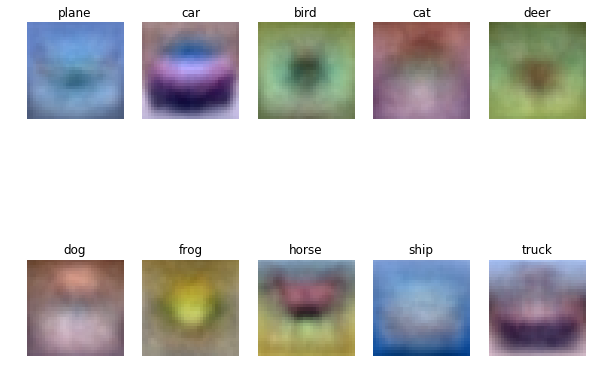

In [15]:
# Visualize the learned weights for each class
w = best_softmax.W[:-1,:] # strip out the bias
w = w.reshape(32, 32, 3, 10)

w_min, w_max = np.min(w), np.max(w)

classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
for i in range(10):
    plt.subplot(2, 5, i + 1)
    
    # Rescale the weights to be between 0 and 255
    wimg = 255.0 * (w[:, :, :, i].squeeze() - w_min) / (w_max - w_min)
    plt.imshow(wimg.astype('uint8'))
    plt.axis('off')
    plt.title(classes[i])